Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
data_root = os.path.join('.', 'notMNIST_data') # Change me to store data elsewhere
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001
minibatch_loss = np.zeros(num_steps)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        minibatch_loss[step] = l
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.346070
Minibatch accuracy: 6.2%
Validation accuracy: 10.5%
Minibatch loss at step 50: 1.484529
Minibatch accuracy: 56.2%
Validation accuracy: 61.5%
Minibatch loss at step 100: 1.119923
Minibatch accuracy: 62.5%
Validation accuracy: 63.9%
Minibatch loss at step 150: 0.317201
Minibatch accuracy: 81.2%
Validation accuracy: 73.9%
Minibatch loss at step 200: 1.011246
Minibatch accuracy: 68.8%
Validation accuracy: 77.4%
Minibatch loss at step 250: 1.350955
Minibatch accuracy: 68.8%
Validation accuracy: 77.5%
Minibatch loss at step 300: 0.345278
Minibatch accuracy: 87.5%
Validation accuracy: 79.5%
Minibatch loss at step 350: 0.505241
Minibatch accuracy: 93.8%
Validation accuracy: 76.5%
Minibatch loss at step 400: 0.218335
Minibatch accuracy: 100.0%
Validation accuracy: 79.9%
Minibatch loss at step 450: 0.857033
Minibatch accuracy: 87.5%
Validation accuracy: 77.7%
Minibatch loss at step 500: 0.588678
Minibatch accuracy: 87.5%
Validation accuracy: 80.5%
M

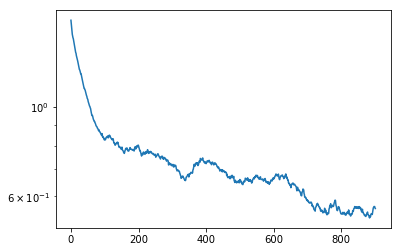

In [7]:
N = 100
minibatch_loss_filter = np.convolve(minibatch_loss, np.ones((N,))/N, mode='valid')
plt.semilogy(minibatch_loss_filter)
plt.show()

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [8]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases, conv

    # Training computation.
    logits, train_conv = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_logits, valid_conv = model(tf_valid_dataset)
    valid_prediction = tf.nn.softmax(valid_logits)
    test_logits, test_conv = model(tf_test_dataset)
    test_prediction = tf.nn.softmax(test_logits)

In [9]:
num_steps = 1001
minibatch_loss = np.zeros(num_steps)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        minibatch_loss[step] = l
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    conv_trained = session.run([train_conv], feed_dict=feed_dict)

Initialized
Minibatch loss at step 0: 3.258948
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.648412
Minibatch accuracy: 37.5%
Validation accuracy: 50.8%
Minibatch loss at step 100: 0.922267
Minibatch accuracy: 68.8%
Validation accuracy: 57.4%
Minibatch loss at step 150: 0.330087
Minibatch accuracy: 87.5%
Validation accuracy: 73.8%
Minibatch loss at step 200: 0.990209
Minibatch accuracy: 81.2%
Validation accuracy: 79.0%
Minibatch loss at step 250: 1.359517
Minibatch accuracy: 56.2%
Validation accuracy: 78.4%
Minibatch loss at step 300: 0.354573
Minibatch accuracy: 87.5%
Validation accuracy: 81.1%
Minibatch loss at step 350: 0.397538
Minibatch accuracy: 93.8%
Validation accuracy: 79.3%
Minibatch loss at step 400: 0.157880
Minibatch accuracy: 100.0%
Validation accuracy: 81.1%
Minibatch loss at step 450: 0.745121
Minibatch accuracy: 81.2%
Validation accuracy: 80.1%
Minibatch loss at step 500: 0.681598
Minibatch accuracy: 87.5%
Validation accuracy: 82.2%


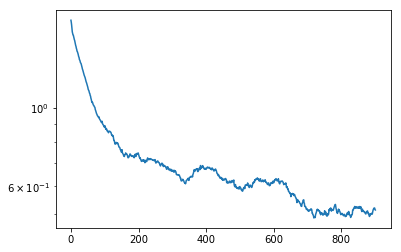

In [10]:
N = 100
minibatch_loss_filter = np.convolve(minibatch_loss, np.ones((N,))/N, mode='valid')
plt.semilogy(minibatch_loss_filter)
plt.show()

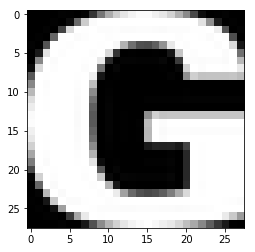

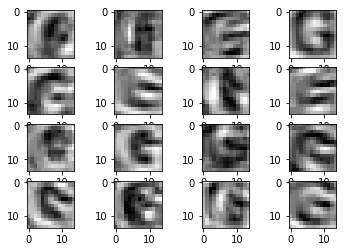

In [11]:
# Display original image and trained convolved images
image_ind = 0
plt.figure(1)
plt.imshow(batch_data[image_ind,:,:,0])
plt.gray()
plt.show()
plt.figure(2)
for i in np.arange(depth):
    offset = i * image_size // 2
    plt.subplot(depth // 4, 4, i+1)
    plt.imshow(conv_trained[0][image_ind,:,:,i])
    plt.gray()
plt.show()

Find a misclassified letter

In [18]:
np.argmax(predictions, 1)

array([6, 9, 5, 1, 3, 9, 8, 7, 1, 7, 5, 5, 5, 1, 8, 1])

In [19]:
np.argmax(batch_labels, 1)

array([6, 9, 5, 1, 3, 9, 8, 7, 1, 7, 5, 5, 8, 1, 8, 1])

In [20]:
np.argmax(predictions, 1) == np.argmax(batch_labels, 1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True], dtype=bool)

8
5


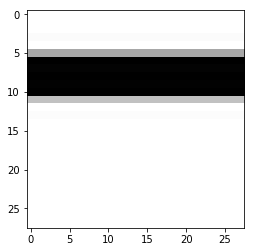

In [21]:
print(np.argmax(batch_labels,1)[12])
print(np.argmax(predictions,1)[12])
plt.imshow(batch_data[12,:,:,0])
plt.gray()
plt.show()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
learning_rate = 0.001
log_dir = os.path.join(data_root, 'logs_v3')
if not os.path.exists(log_dir):
    print('Directory %s does not exist. Creating it...' % log_dir)
    os.makedirs(log_dir)
    print('Created directory %s.' % log_dir)
    
save_dir = os.path.join(data_root, 'save_v3')
if not os.path.exists(save_dir):
    print('Directory %s does not exist. Creating it...' % save_dir)
    os.makedirs(save_dir)
    print('Created directory %s.' % save_dir)

graph = tf.Graph()

with graph.as_default():

    # Input data.
    # TODO: Be able to input data from train, valid, or test, in batch or entirety
    with tf.name_scope('input'):
        input_data = tf.placeholder(
            tf.float32, shape=(None, image_size, image_size, num_channels),
            name='input_data')
        input_labels = tf.placeholder(tf.float32, shape=(None, num_labels),
            name='input_labels')
        tf.summary.image('input', input_data, 10)

    # Variables.
    def weight_variable(shape):
        """Create a weight variable with appropriate initialization."""
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        """Create a bias variable with appropriate initialization."""
        initial = tf.constant(1.0, shape=shape)
        return tf.Variable(initial)
    
    def variable_summaries(var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean', mean)
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)
            
    def conv_layer(input_tensor, patch_size, input_channels, output_channels, layer_name, act=tf.nn.relu):
        """Reusable code for making a simple neural net layer.
        It does a 2d convolution, bias add, and then uses ReLU to nonlinearize.
        It also sets up name scoping so that the resultant graph is easy to read,
        and adds a number of summary ops.
        """
        # Adding a name scope ensures logical grouping of the layers in the graph.
        with tf.name_scope(layer_name):
            # This Variable will hold the state of the weights for the layer
            layer1_weights = tf.Variable(tf.truncated_normal(
                [patch_size, patch_size, num_channels, depth], stddev=0.1))
            layer1_biases = tf.Variable(tf.zeros([depth]))
    
            with tf.name_scope('weights'):
                weights = weight_variable([patch_size, patch_size, input_channels, output_channels])
                variable_summaries(weights)
            with tf.name_scope('biases'):
                biases = bias_variable([output_channels])
                variable_summaries(biases)
            with tf.name_scope('conv_plus_b'):
                preactivate = tf.nn.conv2d(input_tensor, weights, [1, 1, 1, 1], padding='SAME') + biases
                tf.summary.histogram('pre_activations', preactivate)
            activations = act(preactivate, name='activation')
            tf.summary.histogram('activations', activations)
            return activations
        
    def pool_layer(input_tensor, layer_name):
        """Reusable code for making a simple max pooling layer
        """
        # Adding a name scope ensures logical grouping of the layers in the graph.
        with tf.name_scope(layer_name):
            pool = tf.nn.max_pool(input_tensor, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            return pool
    
    def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
        """Reusable code for making a simple neural net layer.
        It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
        It also sets up name scoping so that the resultant graph is easy to read,
        and adds a number of summary ops.
        """
        # Adding a name scope ensures logical grouping of the layers in the graph.
        with tf.name_scope(layer_name):
            # This Variable will hold the state of the weights for the layer
            with tf.name_scope('weights'):
                weights = weight_variable([input_dim, output_dim])
                variable_summaries(weights)
            with tf.name_scope('biases'):
                biases = bias_variable([output_dim])
                variable_summaries(biases)
            with tf.name_scope('Wx_plus_b'):
                preactivate = tf.matmul(input_tensor, weights) + biases
                tf.summary.histogram('pre_activations', preactivate)
            activations = act(preactivate, name='activation')
            tf.summary.histogram('activations', activations)
            return activations
    
    # Model.
    conv1 = conv_layer(input_data, patch_size, num_channels, depth, 'conv1')
    pool1 = pool_layer(conv1, 'pool1')
    conv2 = conv_layer(pool1, patch_size, depth, depth, 'conv2')
    pool2 = pool_layer(conv2, 'pool2')
    
    with tf.name_scope('image_reshape'):
        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])

    hidden1 = nn_layer(reshape, image_size // 4 * image_size // 4 * depth, num_hidden, 'hidden1')
    hidden2 = nn_layer(hidden1, num_hidden, num_hidden, 'hidden2')
    
    # TODO: Try adding dropout at this step.
    logits = nn_layer(hidden2, num_hidden, num_labels, 'hidden3', act=tf.identity)

    # Training computation.
    with tf.name_scope('cross_entropy'):
        diff = tf.nn.softmax_cross_entropy_with_logits(labels=input_labels, logits=logits)
        with tf.name_scope('total'):
            cross_entropy = tf.reduce_mean(diff)
    tf.summary.scalar('cross_entropy', cross_entropy)
    
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(
            cross_entropy)

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(input_labels, 1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

    # Merge all the summaries
    merged = tf.summary.merge_all()

Directory ./notMNIST_data/logs_v3 does not exist. Creating it...
Created directory ./notMNIST_data/logs_v3.
Directory ./notMNIST_data/save_v3 does not exist. Creating it...
Created directory ./notMNIST_data/save_v3.


In [6]:
num_steps = 3001

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    valid_writer = tf.summary.FileWriter(log_dir + '/valid')
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps):
        if step % 10 == 0:  # Record summaries and valid-set accuracy
            # TODO: Set up feed_dict for validation set
            feed_dict = {input_data : valid_dataset, input_labels : valid_labels}
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict)
            valid_writer.add_summary(summary, step)
            print('Accuracy at step %s: %s' % (step, acc))
        if step % 100 == 0:
            saver.save(sess, save_dir + '/my-model-new', global_step=step)
        # Record train set summaries, and train
        if step % 100 == 99:  # Record execution stats
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {input_data : batch_data, input_labels : batch_labels}
            summary, _ = sess.run([merged, train_step],
                                  feed_dict=feed_dict,
                                  options=run_options,
                                  run_metadata=run_metadata)
            train_writer.add_run_metadata(run_metadata, 'step%03d' % step)
            train_writer.add_summary(summary, step)
            print('Adding run metadata for', step)
        else:  # Record a summary
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {input_data : batch_data, input_labels : batch_labels}
            summary, _ = sess.run([merged, train_step], feed_dict=feed_dict)
            train_writer.add_summary(summary, step)
    train_writer.close()
    valid_writer.close()

Initialized
Accuracy at step 0: 0.0999
Accuracy at step 10: 0.1008
Accuracy at step 20: 0.1027
Accuracy at step 30: 0.2037
Accuracy at step 40: 0.3024
Accuracy at step 50: 0.2724
Accuracy at step 60: 0.2331
Accuracy at step 70: 0.3556
Accuracy at step 80: 0.5685
Accuracy at step 90: 0.5343
Adding run metadata for 99
Accuracy at step 100: 0.6268
Accuracy at step 110: 0.6454
Accuracy at step 120: 0.6411
Accuracy at step 130: 0.668
Accuracy at step 140: 0.7199
Accuracy at step 150: 0.7153
Accuracy at step 160: 0.7403
Accuracy at step 170: 0.7327
Accuracy at step 180: 0.753
Accuracy at step 190: 0.7563
Adding run metadata for 199
Accuracy at step 200: 0.7692
Accuracy at step 210: 0.7778
Accuracy at step 220: 0.7748
Accuracy at step 230: 0.7768
Accuracy at step 240: 0.7783
Accuracy at step 250: 0.7711
Accuracy at step 260: 0.7809
Accuracy at step 270: 0.7229
Accuracy at step 280: 0.7829
Accuracy at step 290: 0.765
Adding run metadata for 299
Accuracy at step 300: 0.7814
Accuracy at step 310